# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [1]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "data/TP4_images/"


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [3]:
num_classes = len(north_dataset.classes)
print(f"Number of classes: {num_classes}")
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

Number of classes: 2


In [4]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [5]:
def precompute_features(
    model: models.ResNet, dataset: torch.utils.data.Dataset, device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    If the model is $f \circ g$ where $f$ is the last layer and $g$ is
    the rest of the model, it is not necessary to recompute $g(x)$ at
    each epoch as $g$ is fixed. Hence you can precompute $g(x)$ and
    create a new dataset
    $\mathcal{X}_{\text{train}}' = \{(g(x_n),y_n)\}_{n\leq N_{\text{train}}}$

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for the computation

    Returns:
    --------
    torch.utils.data.Dataset
        The new dataset with the features precomputed
    """

    model.eval()
    model.to(device)

    # Remove the last layer
    feature_extractor = nn.Sequential(*list(model.children())[:-1])

    features_list = []
    labels_list = []
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            features = feature_extractor(images)
            features = features.squeeze()
            features_list.append(features.cpu())
            labels_list.append(labels)

    features_tensor = torch.cat(features_list)
    labels_tensor = torch.cat(labels_list)

    return torch.utils.data.TensorDataset(features_tensor, labels_tensor)

### Training process

In [6]:
import numpy as np

# Freeze all layers except the last one
for param in base_model.parameters():
    param.requires_grad = False
base_model.fc.weight.requires_grad = True
base_model.fc.bias.requires_grad = True

# Precompute features
new_dataset = precompute_features(base_model, north_dataset, device)
print(
    "Class distribution in the training set:",
    torch.bincount(torch.tensor([label for _, label in new_dataset])),
)
train_loader = torch.utils.data.DataLoader(new_dataset, batch_size=32, shuffle=True)

# Train the last layer
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # since we have 2 outputs (logits)

# Class-weighted loss (Uncomment to use)
# counts = torch.bincount(torch.tensor([label for _, label in new_dataset]))
# weights = 1.0 / counts.float()
# weights = weights / weights.sum() * len(counts)
# weights = weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)

base_model.fc.to(device)
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    base_model.fc.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = base_model.fc(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(
        f"Epoch [{epoch + 1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%"
    )

Class distribution in the training set: tensor([31, 11])
Epoch [1/10], Loss: 0.9487, Accuracy: 26.19%
Epoch [2/10], Loss: 0.6169, Accuracy: 73.81%
Epoch [3/10], Loss: 0.5982, Accuracy: 73.81%
Epoch [4/10], Loss: 0.6520, Accuracy: 73.81%
Epoch [5/10], Loss: 0.7250, Accuracy: 73.81%
Epoch [6/10], Loss: 0.6463, Accuracy: 73.81%
Epoch [7/10], Loss: 0.5530, Accuracy: 73.81%
Epoch [8/10], Loss: 0.5838, Accuracy: 73.81%
Epoch [9/10], Loss: 0.6015, Accuracy: 73.81%
Epoch [10/10], Loss: 0.6129, Accuracy: 73.81%


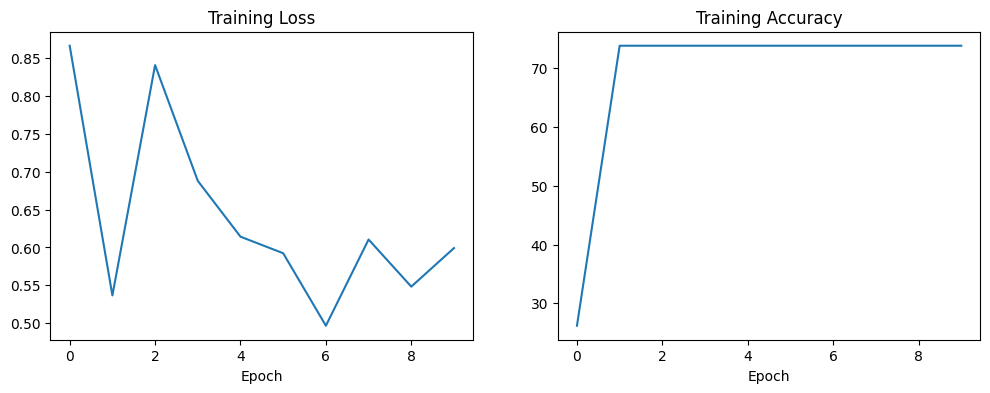

Test Accuracy: 50.00%


In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

# Precompute features for the test set
new_test_dataset = precompute_features(base_model, test_dataset, device)
precomputed_test_loader = torch.utils.data.DataLoader(
    new_test_dataset, batch_size=32, shuffle=False
)

# Evaluate on the test set
base_model.fc.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in precomputed_test_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = base_model.fc(features)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


In [7]:
from utils import precompute_features

<div class="alert alert-info">  
We first loaded a pretrained ResNet18 model and replace its last fully connected layer to fit our binary classification problem. We then froze all layers except the last one to only train the final layer. However, since the dataset used was small and unbalanced, the model performed poorly on both the training and test sets.

The results indicate that training only the last layer on a very small and imbalanced dataset severely limits the model’s ability to learn meaningful decision boundaries. The training set contains only 42 samples (31 from one class and 11 from the other), which is insufficient for the model to generalize well. The imbalance further exacerbates the issue, as the model tends to always predict the majority class. This behavior is reflected in the training accuracy stabilizing at 73.81%, which closely matches the proportion of the majority class (31/42 $\approx$ 74%). The test accuracy of 50% further confirms the lack of generalization, indicating near-random performance on unseen data.


While a class-weighted loss function was implemented to address the class imbalance, it did not significantly improve the model's performance. When the weights were too similar, their effect was negligible and the model reverted to majority-class behavior, whereas strongly unbalanced weights led to unstable training and even poorer performance.

Overall, the combination of severe class imbalance, very small dataset size, and freezing all but the last layer restricts the model’s capacity to adapt, making it difficult to achieve reliable or generalizable performance under these conditions. 
</div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

In [8]:
# Load the base model with default weights
base_model = models.resnet18(weights="DEFAULT")
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

# As before, freeze all layers except the last one
for param in base_model.parameters():
    param.requires_grad = False
base_model.fc.weight.requires_grad = True
base_model.fc.bias.requires_grad = True

# Precompute features
new_dataset = precompute_features(base_model, north_dataset, device)
train_loader = torch.utils.data.DataLoader(new_dataset, batch_size=32, shuffle=True)

# Train the last layer
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=0.001)

# Include weights in the loss function
criterion = (
    nn.CrossEntropyLoss()
)  # incorporating weights did not help here so we skip it

base_model.fc.to(device)
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    base_model.fc.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = base_model.fc(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(
        f"Epoch [{epoch + 1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%"
    )

Epoch [1/10], Loss: 0.7877, Accuracy: 35.71%
Epoch [2/10], Loss: 0.6608, Accuracy: 73.81%
Epoch [3/10], Loss: 0.5060, Accuracy: 73.81%
Epoch [4/10], Loss: 0.7972, Accuracy: 73.81%
Epoch [5/10], Loss: 0.4307, Accuracy: 73.81%
Epoch [6/10], Loss: 0.4544, Accuracy: 73.81%
Epoch [7/10], Loss: 0.4188, Accuracy: 78.57%
Epoch [8/10], Loss: 0.3827, Accuracy: 80.95%
Epoch [9/10], Loss: 0.3812, Accuracy: 92.86%
Epoch [10/10], Loss: 0.3469, Accuracy: 92.86%


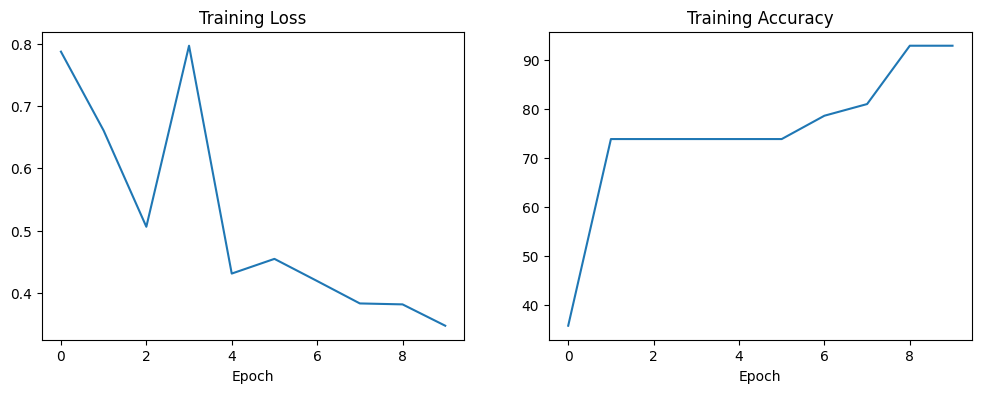

Test Accuracy: 80.95%


In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

# Precompute features for the test set
new_test_dataset = precompute_features(base_model, test_dataset, device)
precomputed_test_loader = torch.utils.data.DataLoader(
    new_test_dataset, batch_size=32, shuffle=False
)

# Evaluate on the test set
base_model.fc.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for features, labels in precomputed_test_loader:
        features, labels = features.to(device), labels.to(device)

        outputs = base_model.fc(features)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


In [10]:
torch.save(base_model.fc.state_dict(), "last_layer_finetune.pth")

In [11]:
from utils import LastLayer


resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
fc.fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

<div class="alert alert-info"> 
LoRA (Low-Rank Adaptation) is a technique designed to efficiently fine-tune large pre-trained models while keeping most of their original weights frozen. Instead of updating all the parameters of the model during fine-tuning, LoRA introduces low-rank matrices that are added to the original weights. This allows the model to adapt to new tasks with a significantly reduced number of trainable parameters, leading to lower computational costs and memory usage.

For convolutional layers, one common approach is the bottleneck decomposition. In this method, a low-rank residual path is added in parallel to the original convolutional layer. This residual path consists of two convolutional layers: the first layer reduces the number of channels and the second layer restores it back to the original size. This way, the model can learn task-specific features through the low-rank path while keeping the majority of the pre-trained weights unchanged.

In our implementation, we applied this approach to the each convolutional layer of the ResNet18 model using the peft library. These layers are choosen because they capture essential spatial features in the input data while still benefiting from lightweight adaptation through LoRA.

A drawing of the LoRA process is provided in the `drawing_lora.png` file.
<div>

In [12]:
from peft import LoraConfig, get_peft_model

# Load pretrained model
base_model = models.resnet18(weights="DEFAULT")
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

# Define LoRA configuration and apply it to the model with the targets being the first two convolutional layers
lora_config = LoraConfig(
    r=8, lora_alpha=16, target_modules=["conv1", "conv2"], lora_dropout=0.1, bias="none"
)

lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

# Train LoRA model
train_loader = torch.utils.data.DataLoader(north_dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(lora_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

lora_model.to(device)
epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    lora_model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = lora_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(
        f"Epoch [{epoch + 1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%"
    )

trainable params: 276,632 || all params: 11,454,170 || trainable%: 2.4151
Epoch [1/10], Loss: 0.8398, Accuracy: 30.95%
Epoch [2/10], Loss: 0.6990, Accuracy: 40.48%
Epoch [3/10], Loss: 0.6192, Accuracy: 59.52%
Epoch [4/10], Loss: 0.2971, Accuracy: 88.10%
Epoch [5/10], Loss: 0.1836, Accuracy: 97.62%
Epoch [6/10], Loss: 0.1017, Accuracy: 97.62%
Epoch [7/10], Loss: 0.0704, Accuracy: 97.62%
Epoch [8/10], Loss: 0.0164, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0098, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0080, Accuracy: 100.00%


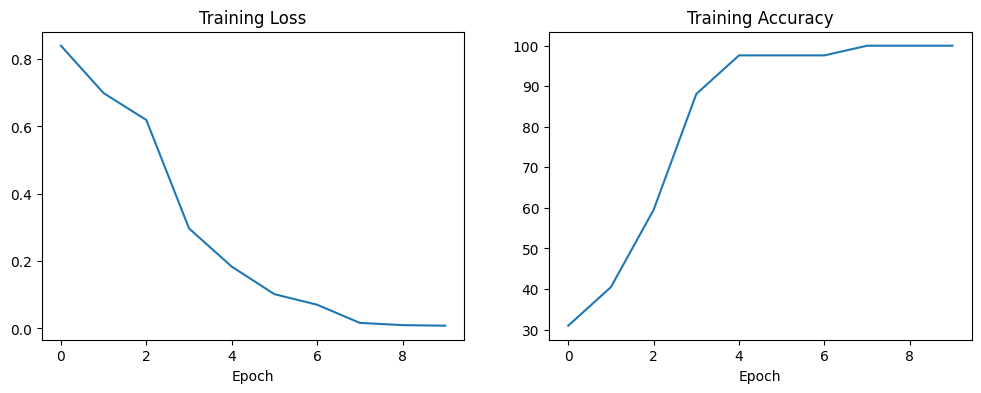

Test Accuracy: 83.33%


In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
lora_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = lora_model(images)

        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")


In [14]:
torch.save(lora_model.state_dict(), "lora_resnet.pth")

## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

<div class="alert alert-info"> 
CutMix is a data augmentation technique used during the training of deep learning models, particularly in image classification tasks. Instead of applying simple transformations like rotation or flipping, CutMix creates new training samples by cutting out a rectangular region from one image and pasting it onto another image. The labels of the new images are also mixed proportionally based on the area of the cut-out region, effectively creating a soft label that encourages the model to learn from both images simultaneously. This helps improve the model's robustness, generalization, and robustness.

A drawing illustrating the CutMix process is provided in the `cutmix.png` file.
</div>

In [19]:
## Data Augmentation
from torchvision.transforms import v2

transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=15),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        v2.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Reload dataset with data augmentation and define CutMix
train_dataset_aug = datasets.ImageFolder(
    dir_path + "north_dataset_sample", transform=transform
)
train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_aug, batch_size=32, shuffle=True
)
cutmix = v2.CutMix(num_classes=2)

# Train loader with data augmentation and CutMix
lora_model_aug = models.resnet18(weights="DEFAULT")
lora_model_aug.fc = nn.Linear(lora_model_aug.fc.in_features, num_classes)
lora_config = LoraConfig(
    r=8, lora_alpha=16, target_modules=["conv1", "conv2"], lora_dropout=0.1, bias="none"
)
lora_model_aug = get_peft_model(lora_model_aug, lora_config)

optimizer = torch.optim.Adam(lora_model_aug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

lora_model_aug.to(device)
train_losses = []
epochs = 10

for epoch in range(epochs):
    lora_model_aug.train()
    epoch_loss = 0

    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)

        # Apply CutMix with probability 0.5 (it is worth noting that CutMix introduce soft labels and therefore we cannot use accuracy here))
        if torch.rand(1).item() < 0.5:
            images, labels = cutmix(images, labels)

        optimizer.zero_grad()
        outputs = lora_model_aug(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader_aug))
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_losses[-1]:.4f}")

Epoch [1/10], Loss: 0.5963
Epoch [2/10], Loss: 0.6633
Epoch [3/10], Loss: 0.5506
Epoch [4/10], Loss: 0.3165
Epoch [5/10], Loss: 0.4367
Epoch [6/10], Loss: 0.1426
Epoch [7/10], Loss: 0.0927
Epoch [8/10], Loss: 0.3584
Epoch [9/10], Loss: 0.3539
Epoch [10/10], Loss: 0.0303


Test Accuracy: 83.33%


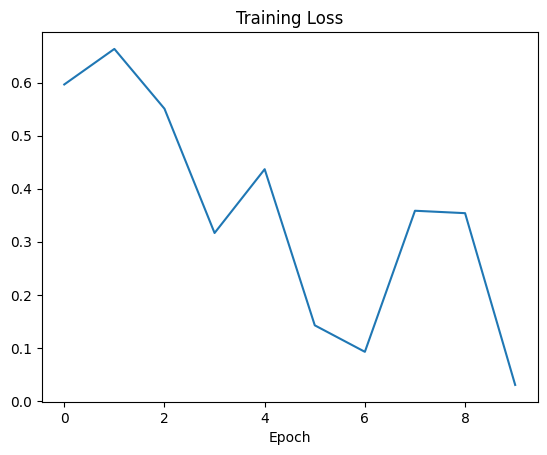

In [20]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")

# Evaluate on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
lora_model_aug.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = lora_model_aug(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [21]:
lora_model = lora_model_aug.merge_and_unload()
assert isinstance(lora_model, models.ResNet)

In [22]:
torch.save(lora_model.state_dict(), "daug_resnet.pth")

## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 